<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-15-2020.csv"

#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/
#csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,213779,312233
34,NJ,71030,72991
21,MA,29918,102105
24,MI,28059,61638
41,PA,26490,111094
16,IL,24593,92336
5,CA,24424,192062
10,FL,22511,190998
20,LA,21951,99977
47,TX,15492,136318


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-7:]

,date,positive,PCT
41,2020-04-09,458635,0.724936
42,2020-04-10,493252,0.779653
43,2020-04-11,522843,0.826425
44,2020-04-12,551826,0.872237
45,2020-04-13,576774,0.911671
46,2020-04-14,602473,0.952292
47,2020-04-15,632656,1.000000


In [9]:
dfCAPos[-7:]

,date,positive,PCT
36,2020-04-09,18309,0.749632
37,2020-04-10,19472,0.797249
38,2020-04-11,19472,0.797249
39,2020-04-12,21794,0.892319
40,2020-04-13,22348,0.915002
41,2020-04-14,23338,0.955536
42,2020-04-15,24424,1.000000


In [10]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-11,522843,2142823,16593,51409.0,58549.0,13563.0,1228.0,5978.0,41.0,31631.0,20355,58549.0,2682259,2665666.0,2665666.0,1867.0,2979.0,106793.0,29591.0,136384.0
2020-04-12,551826,2254066,16419,51413.0,61201.0,13917.0,1455.0,5986.0,160.0,34151.0,21919,61201.0,2822311,2805892.0,2805892.0,1564.0,2652.0,111243.0,28983.0,140226.0
2020-04-13,576774,2358232,17159,50968.0,62673.0,13632.0,1628.0,6168.0,210.0,35442.0,23369,62673.0,2952165,2935006.0,2935006.0,1450.0,1472.0,104166.0,24948.0,129114.0
2020-04-14,602473,2479147,16615,54215.0,67547.0,14039.0,1715.0,5975.0,221.0,37645.0,25668,67547.0,3098235,3081620.0,3081620.0,2299.0,4874.0,120915.0,25699.0,146614.0
2020-04-15,632656,2610099,16901,58361.0,69603.0,14667.0,1783.0,6032.0,223.0,39405.0,28160,69603.0,3259656,3242755.0,3242755.0,2492.0,2056.0,130952.0,30183.0,161135.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-11,19472,152604,13200,5236.0,0.0,1591.0,0.0,0.0,0.0,0.0,541,0.0,185276,172076.0,172076.0,0.0,0.0,7213.0,0.0,7213.0
2020-04-12,21794,168534,13200,5234.0,0.0,1539.0,0.0,0.0,0.0,0.0,651,0.0,203528,190328.0,190328.0,110.0,0.0,15930.0,2322.0,18252.0
2020-04-13,22348,168534,13200,3015.0,0.0,1178.0,0.0,0.0,0.0,0.0,687,0.0,204082,190882.0,190882.0,36.0,0.0,0.0,554.0,554.0
2020-04-14,23338,178870,13200,5163.0,0.0,1552.0,0.0,0.0,0.0,0.0,758,0.0,215408,202208.0,202208.0,71.0,0.0,10336.0,990.0,11326.0
2020-04-15,24424,192062,13200,5163.0,0.0,1175.0,0.0,0.0,0.0,0.0,821,0.0,229686,216486.0,216486.0,63.0,0.0,13192.0,1086.0,14278.0


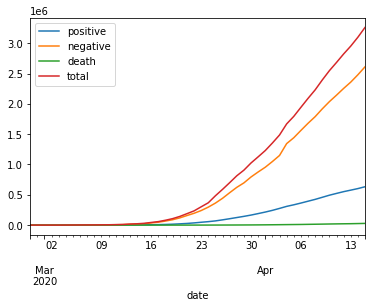

In [12]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [13]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-04-02,187302,3846
2020-04-03,213600,4793
2020-04-04,241703,5854
2020-04-05,273808,7020
2020-04-06,307318,8358
2020-04-07,333811,9559
2020-04-08,363321,10845
2020-04-09,395939,12740
2020-04-10,425889,14665


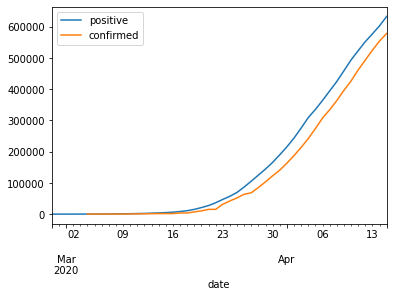

In [14]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [15]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-09,18309,145191,14100,2825.0,0.0,1132.0,0.0,0.0,0.0,0.0,492,0.0,177600,163500.0,163500.0,50.0,0.0,17884.0,1352.0,19236.0
2020-04-10,19472,145391,13900,2897.0,0.0,1145.0,0.0,0.0,0.0,0.0,541,0.0,178763,164863.0,164863.0,49.0,0.0,200.0,1163.0,1363.0
2020-04-11,19472,152604,13200,5236.0,0.0,1591.0,0.0,0.0,0.0,0.0,541,0.0,185276,172076.0,172076.0,0.0,0.0,7213.0,0.0,7213.0
2020-04-12,21794,168534,13200,5234.0,0.0,1539.0,0.0,0.0,0.0,0.0,651,0.0,203528,190328.0,190328.0,110.0,0.0,15930.0,2322.0,18252.0
2020-04-13,22348,168534,13200,3015.0,0.0,1178.0,0.0,0.0,0.0,0.0,687,0.0,204082,190882.0,190882.0,36.0,0.0,0.0,554.0,554.0
2020-04-14,23338,178870,13200,5163.0,0.0,1552.0,0.0,0.0,0.0,0.0,758,0.0,215408,202208.0,202208.0,71.0,0.0,10336.0,990.0,11326.0
2020-04-15,24424,192062,13200,5163.0,0.0,1175.0,0.0,0.0,0.0,0.0,821,0.0,229686,216486.0,216486.0,63.0,0.0,13192.0,1086.0,14278.0


In [16]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    636350
dead          28326
dtype: int64

In [17]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    26686
dead           861
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [19]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                636350
Spain             177644
Italy             165155
Germany           134753
France            134582
United Kingdom     99483
China              83356
Iran               76389
Turkey             69392
Belgium            33573
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [24]:
dfState.loc['FL'].head(7)

,date,positive,current_total,pct
state,,,,
FL,2020-04-15,22511,22511,1.000000
FL,2020-04-14,21367,22511,0.949180
FL,2020-04-13,20601,22511,0.915153
FL,2020-04-12,19355,22511,0.859802
FL,2020-04-11,18494,22511,0.821554
FL,2020-04-10,17531,22511,0.778775
FL,2020-04-09,16364,22511,0.726933


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

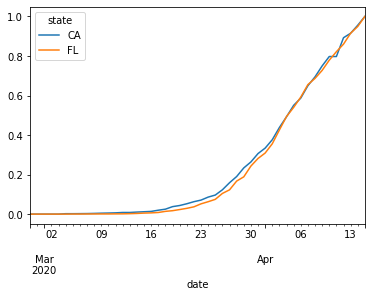

In [26]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

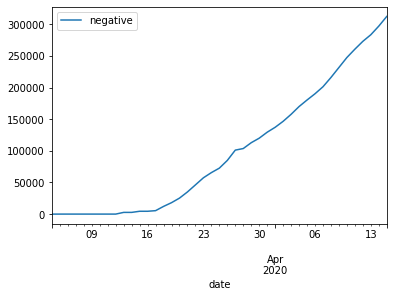

In [28]:
x = dfNYTesting.plot.line()

In [29]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,current_total,pct
404,FL,2020-04-15,22511,22511,1.000000
405,FL,2020-04-14,21367,22511,0.949180
406,FL,2020-04-13,20601,22511,0.915153
407,FL,2020-04-12,19355,22511,0.859802
408,FL,2020-04-11,18494,22511,0.821554
409,FL,2020-04-10,17531,22511,0.778775
410,FL,2020-04-09,16364,22511,0.726933
411,FL,2020-04-08,15455,22511,0.686553
412,FL,2020-04-07,14747,22511,0.655102
413,FL,2020-04-06,13324,22511,0.591888


In [30]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .7)].sort_values(by='pct')


,state,date,positive,current_total,pct
1836,SD,2020-04-12,730,1168,0.625


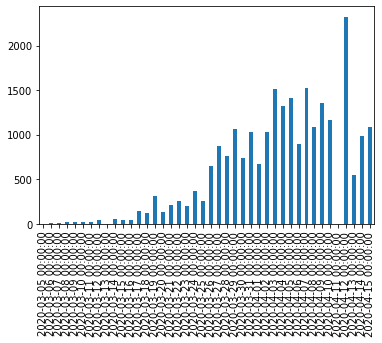

In [31]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [34]:
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")

positive     632656
negative    2610099
pending       16901
death         28160
total       3259656
dtype: int64
Current Infection Rate 19.408674%
Percentage of US affected: 0.201321%
Percentage of US tested/affected: 0.996502%


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [43]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.negative / dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.098920,1.605017
NJ,0.799690,0.821768
LA,0.472187,2.150601
MA,0.434066,1.481392
CT,0.413852,0.992571
RI,0.333125,2.111462
DC,0.311300,1.321716
MI,0.280959,0.617191
PA,0.206921,0.867787
